# Happy Customers

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV

## Load data

In [2]:
feature_desc = [
    'my order was delivered on time',
    'contents of my order was as I expected',
    'I ordered everything I wanted to order',
    'I paid a good price for my order',
    'I am satisfied with my courier',
    'the app makes ordering easy for me',
]

In [3]:
# Load data
data = np.loadtxt('data/ACME-HappinessSurvey2020.csv', delimiter=",", skiprows=1)
data = data.astype(np.float32)

### EDA

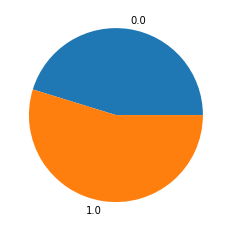

In [4]:
# Distribution of target variable
labels, counts = np.unique(data[:, 0], return_counts=True)
plt.pie(counts, labels=labels)
plt.show()

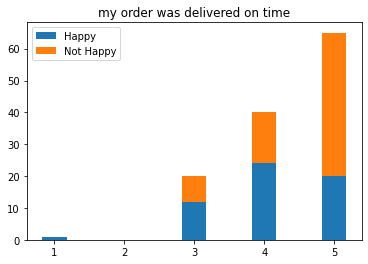

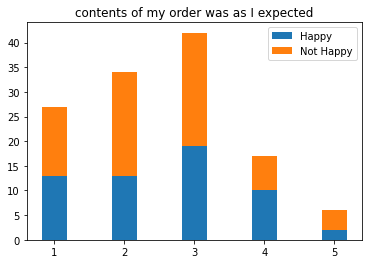

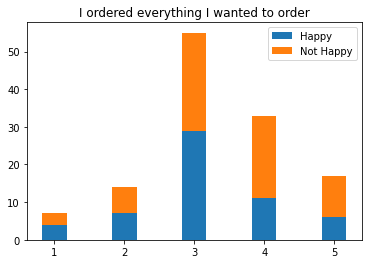

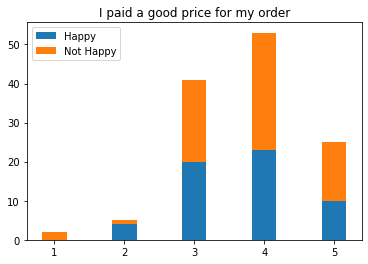

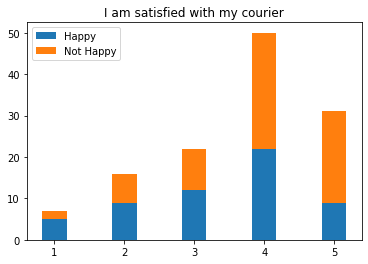

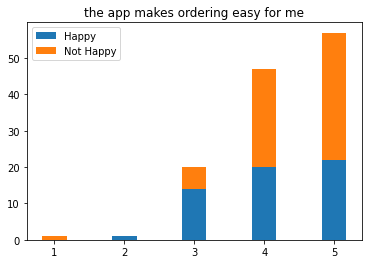

In [6]:
def plot_feature_dist(x, y, title):
    happy = [0] * 5
    not_happy = [0] * 5
    labels = list(range(1, 6))
    for value in range(1, 6):
        matches = y[x == value]
        happy[value - 1] = np.sum(matches == 0)
        not_happy[value - 1] = np.sum(matches == 1)
    fig, ax = plt.subplots()
    ax.bar(labels, happy, 0.35, label='Happy')
    ax.bar(labels, not_happy, 0.35, bottom=happy, label='Not Happy')
    ax.set_title(title)
    ax.legend()
    plt.show()


for i in range(1, 7):
    plot_feature_dist(data[:, i], data[:, 0], feature_desc[i - 1])


# Train/Test Split Sensitivity

We investigate the effect of train/test split on performance.

In [7]:
# Util function
def train_and_eval(model, x_train, x_test, y_train, y_test):
    y_train, y_test = y_train.astype(np.int32), y_test.astype(np.int32)
    model.fit(x_train, y_train.astype(np.int32))
    train_acc = accuracy_score(y_train, model.predict(x_train))
    test_acc = accuracy_score(y_test, model.predict(x_test))
    return train_acc, test_acc

In [8]:
# Normalize features and split into train and test sets
# Stratify guarantees comparable frequency of positive and negative classes in both sets
x_train, x_test, y_train, y_test = train_test_split(data[:, 1:] / 5, data[:, 0], test_size=0.2, stratify=data[:, 0])

print("Train:", x_train.shape, "   ", y_train.shape)
print("Test:", x_test.shape, "   ", y_test.shape)

Train: (100, 6)     (100,)
Test: (26, 6)     (26,)


In [9]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

train_acc, test_acc = train_and_eval(model, x_train, x_test, y_train, y_test)
print(f"Train Acc = {train_acc}")
print(f"Test Acc = {test_acc}")

Train Acc = 0.94
Test Acc = 0.7307692307692307


In [10]:
for i in range(20):
    x_train, x_test, y_train, y_test = train_test_split(data[:, 1:] / 5, data[:, 0], test_size=0.2, stratify=data[:, 0])
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=12345)
    train_acc, test_acc = train_and_eval(model, x_train, x_test, y_train, y_test.astype(np.int32))
    print(f"Run {i} \t Test Acc = {test_acc * 100:.1f}%")

Run 0 	 Test Acc = 53.8%
Run 1 	 Test Acc = 50.0%
Run 2 	 Test Acc = 57.7%
Run 3 	 Test Acc = 57.7%
Run 4 	 Test Acc = 46.2%
Run 5 	 Test Acc = 69.2%
Run 6 	 Test Acc = 46.2%
Run 7 	 Test Acc = 69.2%
Run 8 	 Test Acc = 46.2%
Run 9 	 Test Acc = 50.0%
Run 10 	 Test Acc = 65.4%
Run 11 	 Test Acc = 50.0%
Run 12 	 Test Acc = 53.8%
Run 13 	 Test Acc = 46.2%
Run 14 	 Test Acc = 61.5%
Run 15 	 Test Acc = 53.8%
Run 16 	 Test Acc = 57.7%
Run 17 	 Test Acc = 57.7%
Run 18 	 Test Acc = 57.7%
Run 19 	 Test Acc = 46.2%


**Conclusion:** The accuracy is highly sensitive to train/test split. This is common in small datasets. 

# Train with k-fold cross validation

In [11]:
def train_and_eval_kfold(model, k=5):
    kf = KFold(n_splits=k, shuffle=True)

    train_acc, val_acc = [], []
    for train_index, val_index in kf.split(data):
        x_train, y_train = data[train_index, 1:], data[train_index, 0]
        x_val, y_val = data[val_index, 1:], data[val_index, 0]

        y_train, y_val = y_train.astype(np.int32), y_val.astype(np.int32)
        model.fit(x_train, y_train)

        train_acc += [accuracy_score(y_train, model.predict(x_train))]
        val_acc += [accuracy_score(y_val, model.predict(x_val))]

    return np.mean(train_acc), np.mean(val_acc)

In [12]:
for i in range(20):
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=12345)
    test_acc = train_and_eval_kfold(model)[1]

    print(f"Run {i} \t Test Acc = {test_acc * 100:.1f}%")

Run 0 	 Test Acc = 56.3%
Run 1 	 Test Acc = 58.0%
Run 2 	 Test Acc = 58.8%
Run 3 	 Test Acc = 57.1%
Run 4 	 Test Acc = 57.1%
Run 5 	 Test Acc = 52.3%
Run 6 	 Test Acc = 61.9%
Run 7 	 Test Acc = 56.3%
Run 8 	 Test Acc = 57.2%
Run 9 	 Test Acc = 53.8%
Run 10 	 Test Acc = 62.0%
Run 11 	 Test Acc = 54.7%
Run 12 	 Test Acc = 54.8%
Run 13 	 Test Acc = 55.5%
Run 14 	 Test Acc = 50.1%
Run 15 	 Test Acc = 59.5%
Run 16 	 Test Acc = 57.0%
Run 17 	 Test Acc = 58.7%
Run 18 	 Test Acc = 58.7%
Run 19 	 Test Acc = 50.8%


# Explore other models

In [13]:
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, max_depth=5,
        verbose=False
    ),
    'XGBClassifier': XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=12345
    ),
    'MLP': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        max_iter=1000,
        verbose=False
    ),
    'TabNet': TabNetClassifier(verbose=False)
}

In [14]:
for name, model in models.items():
    train_acc, test_acc = train_and_eval_kfold(model)
    print(f"{name} \t Train = {train_acc * 100:.1f}%   Test = {test_acc * 100:.1f}%")

RandomForest 	 Train = 86.3%   Test = 55.5%
XGBClassifier 	 Train = 94.2%   Test = 57.9%
MLP 	 Train = 95.2%   Test = 51.7%
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
No early stopping will be performed, last training weights will be used.
TabNet 	 Train = 78.1%   Test = 61.2%


# Feature Selection

<AxesSubplot:>

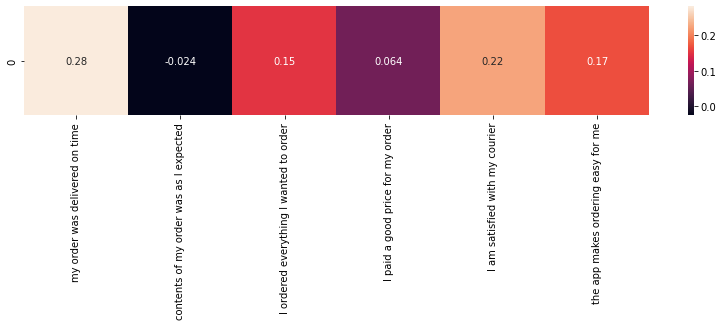

In [22]:
# Pearson Correlation
plt.figure(figsize=(14, 2))
sns.heatmap(pd.DataFrame(data).corr().values[0:1, 1:], annot=True, xticklabels=feature_desc)

In [23]:
# Univariate Feature Selection
kbest_sel = SelectKBest(chi2, k=4)
kbest_sel.fit(data[:, 1:], data[:, 0])

SelectKBest(k=4, score_func=<function chi2 at 0x7f81481bec80>)

In [24]:
kbest_sel.scores_

array([1.44904066, 0.03616135, 0.90010372, 0.106194  , 2.27328624,
       0.54107039])

<AxesSubplot:>

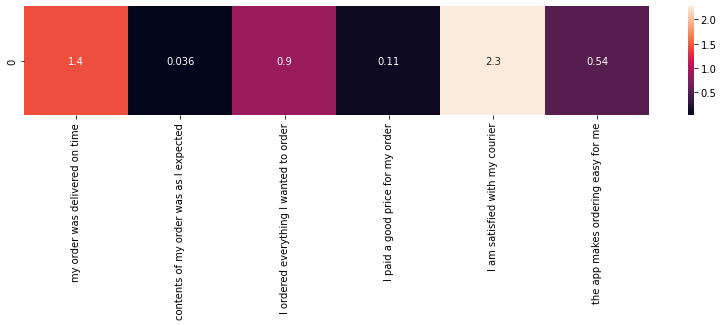

In [25]:
plt.figure(figsize=(14, 2))
sns.heatmap([kbest_sel.scores_], annot=True, xticklabels=feature_desc)

**Conclusion:** Features *X2* and *X4* are the least relevant and hence can be omitted.

